### ЭТАП 1. Exploratory Data Analysis

На этом этапе будет выполнено:
1. _Проверка полноты разметки датасета._
Осуществляем проверку на полноту размеченных данных. Находим изображения, которые на имеют разметки, также ноходим файлы разметки у которых нет пары изображений. При необходимости доразмечиваем данные или удаляем неразмеченные файлы, если их количество составляет меньше 1%.
2. _Анализ распределения классов._
 Проводится исследование по выявлению дисбаланса классов для принятия решения по доработке datasets;
3. _Визуализация тестового изображения._
Отображаем тестовое  с выделенными на нём bounding box'ами и подписанными классами.

In [1]:
#импортируем кастомный класс для анализа датасета
from EDA_dataset import MinecraftDatasetAnalyzer

analisys = MinecraftDatasetAnalyzer(r'mmdetection\datasets')

In [2]:
class_counter, bbox_sizes = analisys.analyze_dataset()

Всего XML файлов: 2305
Всего изображений: 2307


In [3]:
# 1. Проверка полноты данных
analisys.check_dataset_folders()

1. ПРОВЕРКА ПОЛНОТЫ РАЗМЕТКИ ДАТАСЕТА

В папке: train
Без разметки: 2
Изображения: ['Screenshot-188-_png.rf.7990d49953d8657dda9da38d1c75749a', '2023-04-03_19_17_30_png.rf.8ca8dad6210d53c762b3b8df9bbb5db2']
Всего изображений: 2307
Всего XML: 2305
ВЫВОД: Необходимо проверить ['Screenshot-188-_png.rf.7990d49953d8657dda9da38d1c75749a', '2023-04-03_19_17_30_png.rf.8ca8dad6210d53c762b3b8df9bbb5db2']

В папке: valid
Все изображения имеют разметку и отсутствует разметка без изображений.
Всего изображений: 422
Всего XML: 422
ВЫВОД: C valid все норм! Менять ничего не нужно!

В папке: test
Все изображения имеют разметку и отсутствует разметка без изображений.
Всего изображений: 155
Всего XML: 155
ВЫВОД: C test все норм! Менять ничего не нужно!


In [ ]:
# Запуск обучения FCOS (будет отображён прогресс-бар и логи)
from train import main
main()


In [ ]:
# Пример инференса и визуализации результата FCOS
import torch
from data.dataset import VOCDataset
from models.fcos import FCOSDetector
from visualize import plot_detection

dataset = VOCDataset('mmdetection/datasets/minecraft', 'valid', 512)
img, gt_box, gt_label = dataset[0]

model = FCOSDetector(17)
model.load_state_dict(torch.load('artifacts/fcos_minecraft.pt', map_location='cpu'))
model.eval()

with torch.no_grad():
    pred_boxes, pred_scores, pred_labels = model.detect(img)

plot_detection(img, gt_box, gt_label, pred_boxes.cpu(), pred_labels.cpu(), pred_scores.cpu(), thresh=0.2)


In [ ]:
# Оценка метрик детекции на тестовой выборке
import torch
from data.dataset import VOCDataset
from models.fcos import FCOSDetector
from metrics import evaluate_detector

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = VOCDataset('mmdetection/datasets/minecraft', 'test', 512)
model = FCOSDetector(17).to(device)
model.load_state_dict(torch.load('artifacts/fcos_minecraft.pt', map_location=device))

metrics = evaluate_detector(model, dataset, device)
for k, v in metrics.items():
    print(f'{k}: {v:.4f}')



Поскольку в train 2 изображения из 2307 составляют не больше 1%. Принимается решение эти файлы удалить.

2. АНАЛИЗ РСПРЕДЕЛЕНИЯ КЛАССОВ


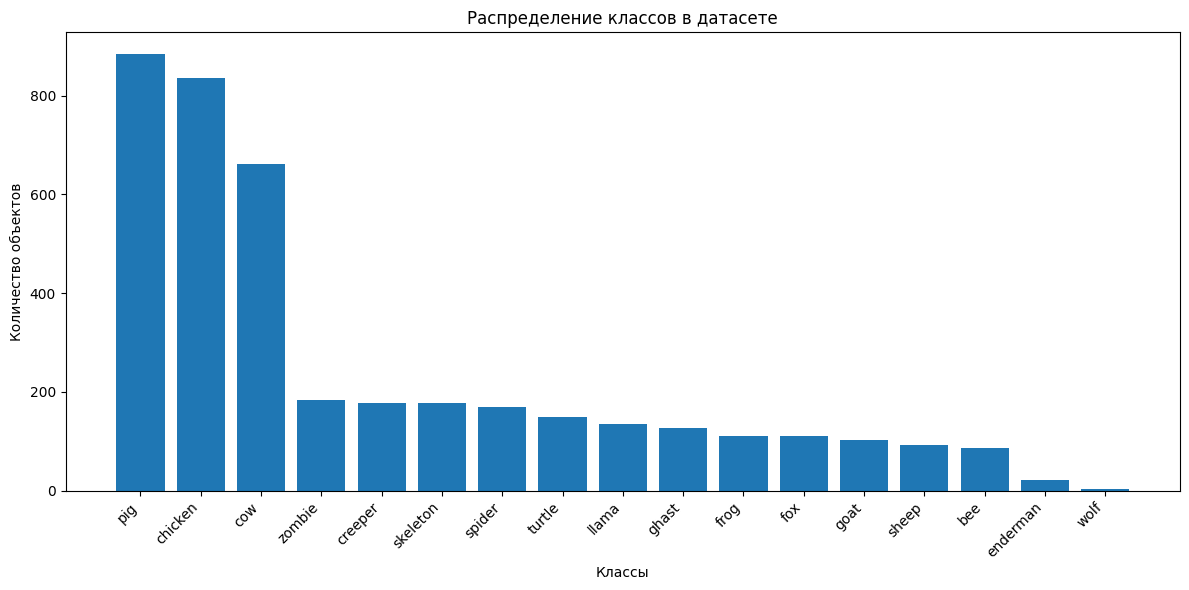

Наибольшее количество: 884
Наименьшее количество: 4
Коэффициент дисбаланса: 221.00


In [4]:
# 2. Анализ распределения классов
analisys.visualize_class_distribution(class_counter)

3. ВИЗУАЛИЗАЦИЯ ПРИМЕРА С bounding boxes


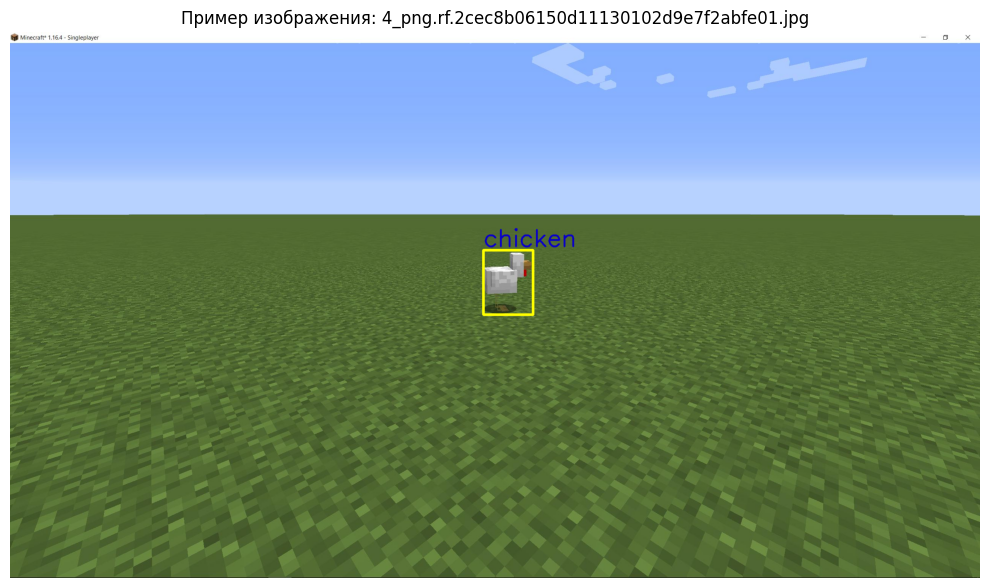

In [5]:
# 3. Визуализация тестового изображения
analisys.visualize_sample('4_png.rf.2cec8b06150d11130102d9e7f2abfe01.jpg')

### Вывод по первому этапу:
1. Выявлено два изображения без разметки в train выборке. Принято решение их удалить.

2. Проверка на распределение классов выявила:
    
    наибольшее количество: 884;
    наименьшее количество: 4;
    коэффициент дисбаланса: 221.00.

Выявлен большой дисбаланс классов 221 к 1. 

Рекомендации к улучшению репрезентативности датасета:
    
    Для класса с 884 экземплярами:
       
        1. Удалить дубликаты/похожие изображения
        2. Оставить наиболее разнообразные примеры
        3. Использовать кластеризацию для выбора representative образцов
    
    Для класса с 4 экземплярами:
        
        1. Геометрические трансформации:
        - Повороты (0-360 градусов)
        - Отражения по горизонтали/вертикали
        - Масштабирование (0.5-1.5x)
        - Сдвиги
        - Искажения перспективы

        2. Пиксельные трансформации:
        - Изменение яркости/контраста
        - Добавление шума
        - Размытие
        - Цветовые искажения

        3. Генерация синтетических данных:
        - Копипаста объектов на разные фоны
        - GAN-генерация
        - Использование предобученных моделей 

3. Отображение на тестовом изображении bounding boxes и наименований клаасса проблемных моментов не выявило.



### ЭТАП 2. Настройка конфигурации моделей

Перед обучением протестируйте инференс на pretrained-модели FCOS в ноутбуке.
Для этого:
1. Скачайте чекпоинт <…>.pth для вашей модели из официального репозитория и положите в папку checkpoints/.
2. В ячейке Jupyter Notebook'а импортируйте предобученный чекпоинт checkpoints/fcos_<…>.pth базовой модели и вашу конфигурацию fcos_minecraft.py.
3. Визуализируйте результат детекции на одном изображении.
4. Сохраните результат в artifacts/inference/test_pretrained.jpg.
После тестирования на инференсе настройте конфигурацию для YOLO. Сначала подготовьте файл datasets/minecraft/data_``voc``.yaml, чтобы YOLO работал с данными в корректной форме.
Проверьте инференс на pretrained-модели YOLOv8s. Именно её вы будете дообучать. Для этого:
В ячейке Jupyter Notebook'а импортируйте модель YOLO и визуализируйте результат на каком-нибудь тестовом примере.
Сохраните результат в папку artifacts/inference/yolo_val/.

Тестирование инференса yolo перед обучением


image 1/1 d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course Computer Vision  CV\Split 1. Object detection\Minecraft_detect\mmdetection\datasets\minecraft\test\-5-_jpg.rf.bc815ec81b67584c880eb373c6de746a.jpg: 512x640 1 parking meter, 1 toilet, 1 refrigerator, 390.1ms
Speed: 6.0ms preprocess, 390.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


Обнаружено объектов: 3


([], [])

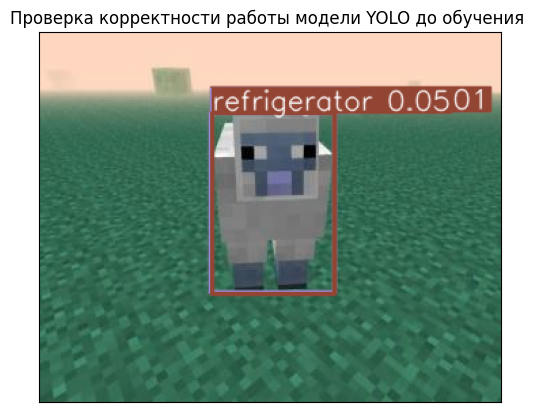

In [19]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

# Создаем директорию для сохранения
os.makedirs('artifacts/inference/yolo_val', exist_ok=True)

# Загружаем модель
model = YOLO('yolov8s.pt')

# Путь к изображению
source = 'mmdetection/datasets/minecraft/test/-5-_jpg.rf.bc815ec81b67584c880eb373c6de746a.jpg'

# Выполняем предсказание
results = model.predict(source, conf=0.01)

# Обрабатываем результат
result = results[0]

# Рисуем bounding boxes на изображении
annotated_image = result.plot()

print(f"Обнаружено объектов: {len(result.boxes)}")

# Показываем результат
plt.imshow(annotated_image)
plt.title("Проверка корректности работы модели YOLO до обучения ")
plt.xticks([])
plt.yticks([])

### ЭТАП 3. Обучение моделей YOLOv8s и FCOS

3.1 Обучение FCOS

In [ ]:
# Запуск обучения FCOS
!python train_fcos.py --config mmdetection/configs/fcos/fcos_minecraft.py --work-dir artifacts/fcos_training

Epoch 1:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 1, Loss: 43.2741, Cls: 0.0006, BBox: 43.2735
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0014, F1: 0.0000


Epoch 2:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 2, Loss: 41.0917, Cls: 0.0004, BBox: 41.0913
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 3:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 3, Loss: 39.4888, Cls: 0.0004, BBox: 39.4884
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0014, F1: 0.0001


Epoch 4:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 4, Loss: 38.3129, Cls: 0.0003, BBox: 38.3126
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0014, F1: 0.0000


Epoch 5:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 5, Loss: 37.3844, Cls: 0.0003, BBox: 37.3841
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 6:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 6, Loss: 36.1931, Cls: 0.0003, BBox: 36.1928
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0043, F1: 0.0000


Epoch 7:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 7, Loss: 35.0812, Cls: 0.0003, BBox: 35.0809
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0057, F1: 0.0001


Epoch 8:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 8, Loss: 34.1022, Cls: 0.0003, BBox: 34.1019
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0043, F1: 0.0001


Epoch 9:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 9, Loss: 33.4504, Cls: 0.0003, BBox: 33.4501
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0014, F1: 0.0000


Epoch 10:   0%|          | 0/2305 [00:00<?, ?it/s]

Epoch: 10, Loss: 32.7402, Cls: 0.0003, BBox: 32.7399
Валидация: mAP: 0.0000, mAP@50: 0.0000, Precision: 0.0000, Recall: 0.0029, F1: 0.0001
Модель сохранена!
Метрики сохранены в metrics.csv


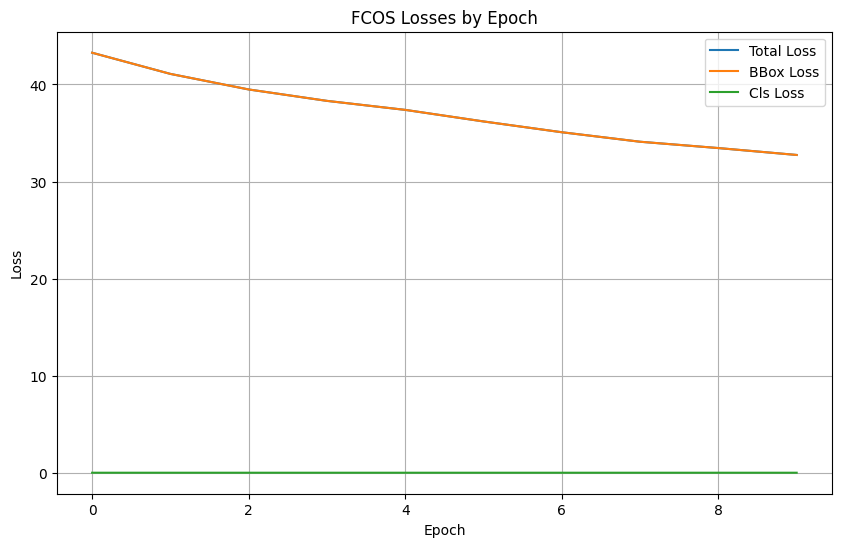

In [11]:
from train import main
main()

Визуализация метрик FCOS

In [12]:
import pandas as pd

fcos_metriks = pd.read_csv(r'artifacts\fcos_scratch\metrics.csv')
fcos_metriks

epoch  total_loss  bbox_loss  cls_loss           mAP        mAP_50  \
0      1   43.274110  43.273464  0.000646  1.315955e-08  3.289888e-08   
1      2   41.091717  41.091333  0.000384  0.000000e+00  0.000000e+00   
2      3   39.488802  39.488447  0.000355  4.311058e-08  1.437019e-07   
3      4   38.312898  38.312565  0.000333  2.955140e-09  2.955140e-08   
4      5   37.384389  37.384071  0.000318  0.000000e+00  0.000000e+00   
5      6   36.193076  36.192769  0.000307  1.531531e-08  9.001141e-08   
6      7   35.081153  35.080854  0.000299  7.222357e-08  5.360776e-07   
7      8   34.102202  34.101914  0.000289  2.963231e-08  2.672984e-07   
8      9   33.450369  33.450084  0.000284  1.612190e-09  1.612190e-08   
9     10   32.740167  32.739889  0.000278  1.870862e-08  1.381897e-07   

   Precision    Recall  F1-score  
0   0.000007  0.001435  0.000014  
1   0.000000  0.000000  0.000000  
2   0.000044  0.001435  0.000085  
3   0.000009  0.001435  0.000018  
4   0.000000  0.000000  0.000000  
5   0.000016  0.004304  0.000033  
6   0.000028  0.005739  0.000055  
7   0.000028  0.004304  0.000055  
8   0.000011  0.001435  0.000022  
9   0.000027  0.002869  0.000054

3.2 Обучение yolov8s

In [ ]:
import os
import sys
import torch

os.environ['PYTHONUNBUFFERED'] = '1'  # Отключаем буферизацию вывода
os.environ['TQDM_DISABLE'] = '0'      # Включаем tqdm

# Перенаправляем stderr в stdout (для прогресс-баров)
sys.stderr = sys.stdout

# Функция для принудительного вывода
def log(message):
    print(message, flush=True)

log("🚀 Начинаем обучение YOLO...")

from ultralytics import YOLO

# Проверяем доступность CUDA
if torch.cuda.is_available():
    device = 0
    log(f"✅ CUDA доступна, используется GPU")
else:
    device = 'cpu'
    log(f"⚠️  CUDA недоступна, используется CPU")

# Создаем директории для артефактов
os.makedirs('artifacts/yolo_training', exist_ok=True)

# Загружаем предобученную модель YOLOv8s
log("Загрузка модели YOLOv8s...")
model = YOLO('yolov8s.pt')

# Настройка параметров обучения 
train_args = {
    'data': 'mmdetection/datasets/minecraft_yolo/data_voc.yaml',
    'epochs': 12,
    'imgsz': 512,
    'batch': 2,
    'workers': 2,
    'amp': True if torch.cuda.is_available() else False,
    'save_period': 1,
    'project': 'artifacts/yolo_training',
    'name': 'yolov8s_minecraft_v1',
    'exist_ok': True,
    'patience': 5,
    'lr0': 0.01,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'verbose': True,  # отображения прогресса
    'plots': True,    # Включаем графики
    'save': True,     # Сохраняем результаты
}

if device == 'cuda':
    train_args['device'] = 0
else:
    train_args['device'] = 'cpu'

log(f"\n📋 Параметры обучения:")
for key, value in train_args.items():
    if key != 'data':
        log(f"  {key}: {value}")

log("\n" + "="*50)
log("🎯 Запуск обучения...")
log("="*50)

# Дообучаем на наших данных
log("⏳ Начало процесса обучения...")
results = model.train(**train_args)

log("\n" + "="*50)
log("✅ Обучение YOLO завершено!")
log("="*50)

# Валидация после обучения
log("\n📊 Запуск валидации...")
metrics = model.val()
log(f"📈 mAP50-95: {metrics.box.map:.4f}")
log(f"📈 mAP50: {metrics.box.map50:.4f}")

🚀 Начинаем обучение YOLO...
⚠️  CUDA недоступна, используется CPU
Загрузка модели YOLOv8s...
d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\.minecraft\lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

Визуализируем метрики обучения yolov8s. 
Более детально изучить метрики на датасете minecraft можно в папке - 'artifacts\yolo_training'

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

yolo_metriks = pd.read_csv(r'artifacts\yolo_training\yolov8s_minecraft_v1\results.csv')
yolo_metriks

epoch        train/box_loss        train/cls_loss  \
0                      1                1.4281               3.19280   
1                      2                1.3331               1.73770   
2                      3                1.2800               1.43400   
3                      4                1.2464               1.25370   
4                      5                1.2562               1.16040   
5                      6                1.2131               1.06650   
6                      7                1.1919               0.98252   
7                      8                1.1394               0.91618   
8                      9                1.1039               0.82850   
9                     10                1.0816               0.78897   
10                    11                1.0371               0.72831   
11                    12                1.0111               0.68347   

          train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
0                1.18330               0.51994               0.25437   
1                1.15190               0.44470               0.32108   
2                1.11660               0.55985               0.34654   
3                1.11320               0.48520               0.33114   
4                1.10830               0.55324               0.31140   
5                1.07160               0.52623               0.42311   
6                1.06820               0.68855               0.38664   
7                1.04130               0.68291               0.35172   
8                1.01650               0.62744               0.42510   
9                1.00600               0.55333               0.35979   
10               0.98479               0.71789               0.40198   
11               0.97185               0.66262               0.38453   

        metrics/mAP50(B)   metrics/mAP50-95(B)          val/box_loss  \
0                0.27315               0.17842                1.1764   
1                0.36724               0.24623                1.2482   
2                0.39506               0.26155                1.2478   
3                0.34089               0.22560                1.1896   
4                0.33485               0.20046                1.3878   
5                0.40659               0.27972                1.2099   
6                0.45553               0.28921                1.1669   
7                0.42426               0.26461                1.2303   
8                0.48233               0.31731                1.1447   
9                0.40510               0.29115                1.1403   
10               0.47809               0.31825                1.1051   
11               0.47774               0.31537                1.1025   

            val/cls_loss          val/dfl_loss                lr/pg0  \
0                 2.9043                1.1103              0.000159   
1                 2.7086                1.1599              0.000291   
2                 2.4243                1.1713              0.000397   
3                 2.4886                1.1851              0.000358   
4                 2.6377                1.2687              0.000358   
5                 2.1058                1.2219              0.000319   
6                 2.0280                1.1723              0.000280   
7                 2.1459                1.2223              0.000240   
8                 1.9222                1.1589              0.000201   
9                 1.9996                1.1502              0.000162   
10                1.8902                1.1395              0.000123   
11                1.8222                1.1326              0.000083   

                  lr/pg1                lr/pg2  
0               0.000159              0.000159  
1               0.000291              0.000291  
2               0.000397              0.000397  
3               0.000358              0.000358  
4               0.000358  

Получаем метрики на тесте FCOS

In [36]:
!python val_fcos.py

mAP50-95: 0.0000
mAP50: 0.0000
Precision: 0.0000
Recall: 0.0029
F1-score: 0.0001
Метрики сохранены в fcos_metrics.csv
  model  mAP50-95  mAP50  precision  recall  f1_score
0  fcos       0.0    0.0        0.0  0.0029    0.0001


d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\val_fcos.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

### ЭТАП 4. Инференс на best models

4.2 Визуализация метрики и результат обучения на 6 примерах из папки test для YOLOv8s

In [35]:
from ultralytics import YOLO
import numpy as np

# Загрузка обученной модели
best_model = r'artifacts\yolo_training\yolov8s_minecraft_v1\weights\best.pt'
model = YOLO(best_model)

# Валидация с выводом метрик
results = model.val(
    data='mmdetection/datasets/minecraft_yolo/data_voc.yaml',
    split='test',  # если у вас есть test раздел
    save=True,  # сохранить результаты в JSON
    save_hybrid=True,  # сохранить гибридные метки
    conf=0.25,  # порог уверенности
    iou=0.45,  # IoU threshold
    device='cpu',  # или 'cuda' или 0 или [0,1,2,3]
)

# Вывод метрик

print(f"mAP50-95: {results.box.map:.2f}")
print(f"mAP50: {results.box.map50:.2f}")
print(f"mAP75: {results.box.map75:.2f}")
print(f"Precision: {np.mean(results.box.p):.2f}")
print(f"Recall: {np.mean(results.box.r):.2f}")
print(f"F1-score: {np.mean(results.box.f1):.2f}")

# Собираем метрики
metrics = {
    'model': 'yolov8s',
    'mAP50-95': round(results.box.map, 4),
    'mAP50': round(results.box.map50, 4),
    'precision': round(np.mean(results.box.p), 4),
    'recall': round(np.mean(results.box.r), 4),
    'f1_score': round(np.mean(results.box.f1), 4),
}

# Сохраняем в CSV
df = pd.DataFrame([metrics])  # Создаем DataFrame из одной строки
df.to_csv('yolo_metrics.csv', mode='a', index=False, header=True)
print("Метрики сохранены в yolo_metrics.csv")
df


d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\.minecraft\lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi

mAP50-95: 0.99
mAP50: 0.99
mAP75: 0.99
Precision: 1.00
Recall: 1.00
F1-score: 1.00
Метрики сохранены в yolo_metrics.csv


model  mAP50-95  mAP50  precision  recall  f1_score
0  yolov8s     0.995  0.995        1.0     1.0       1.0

d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\.minecraft\lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi

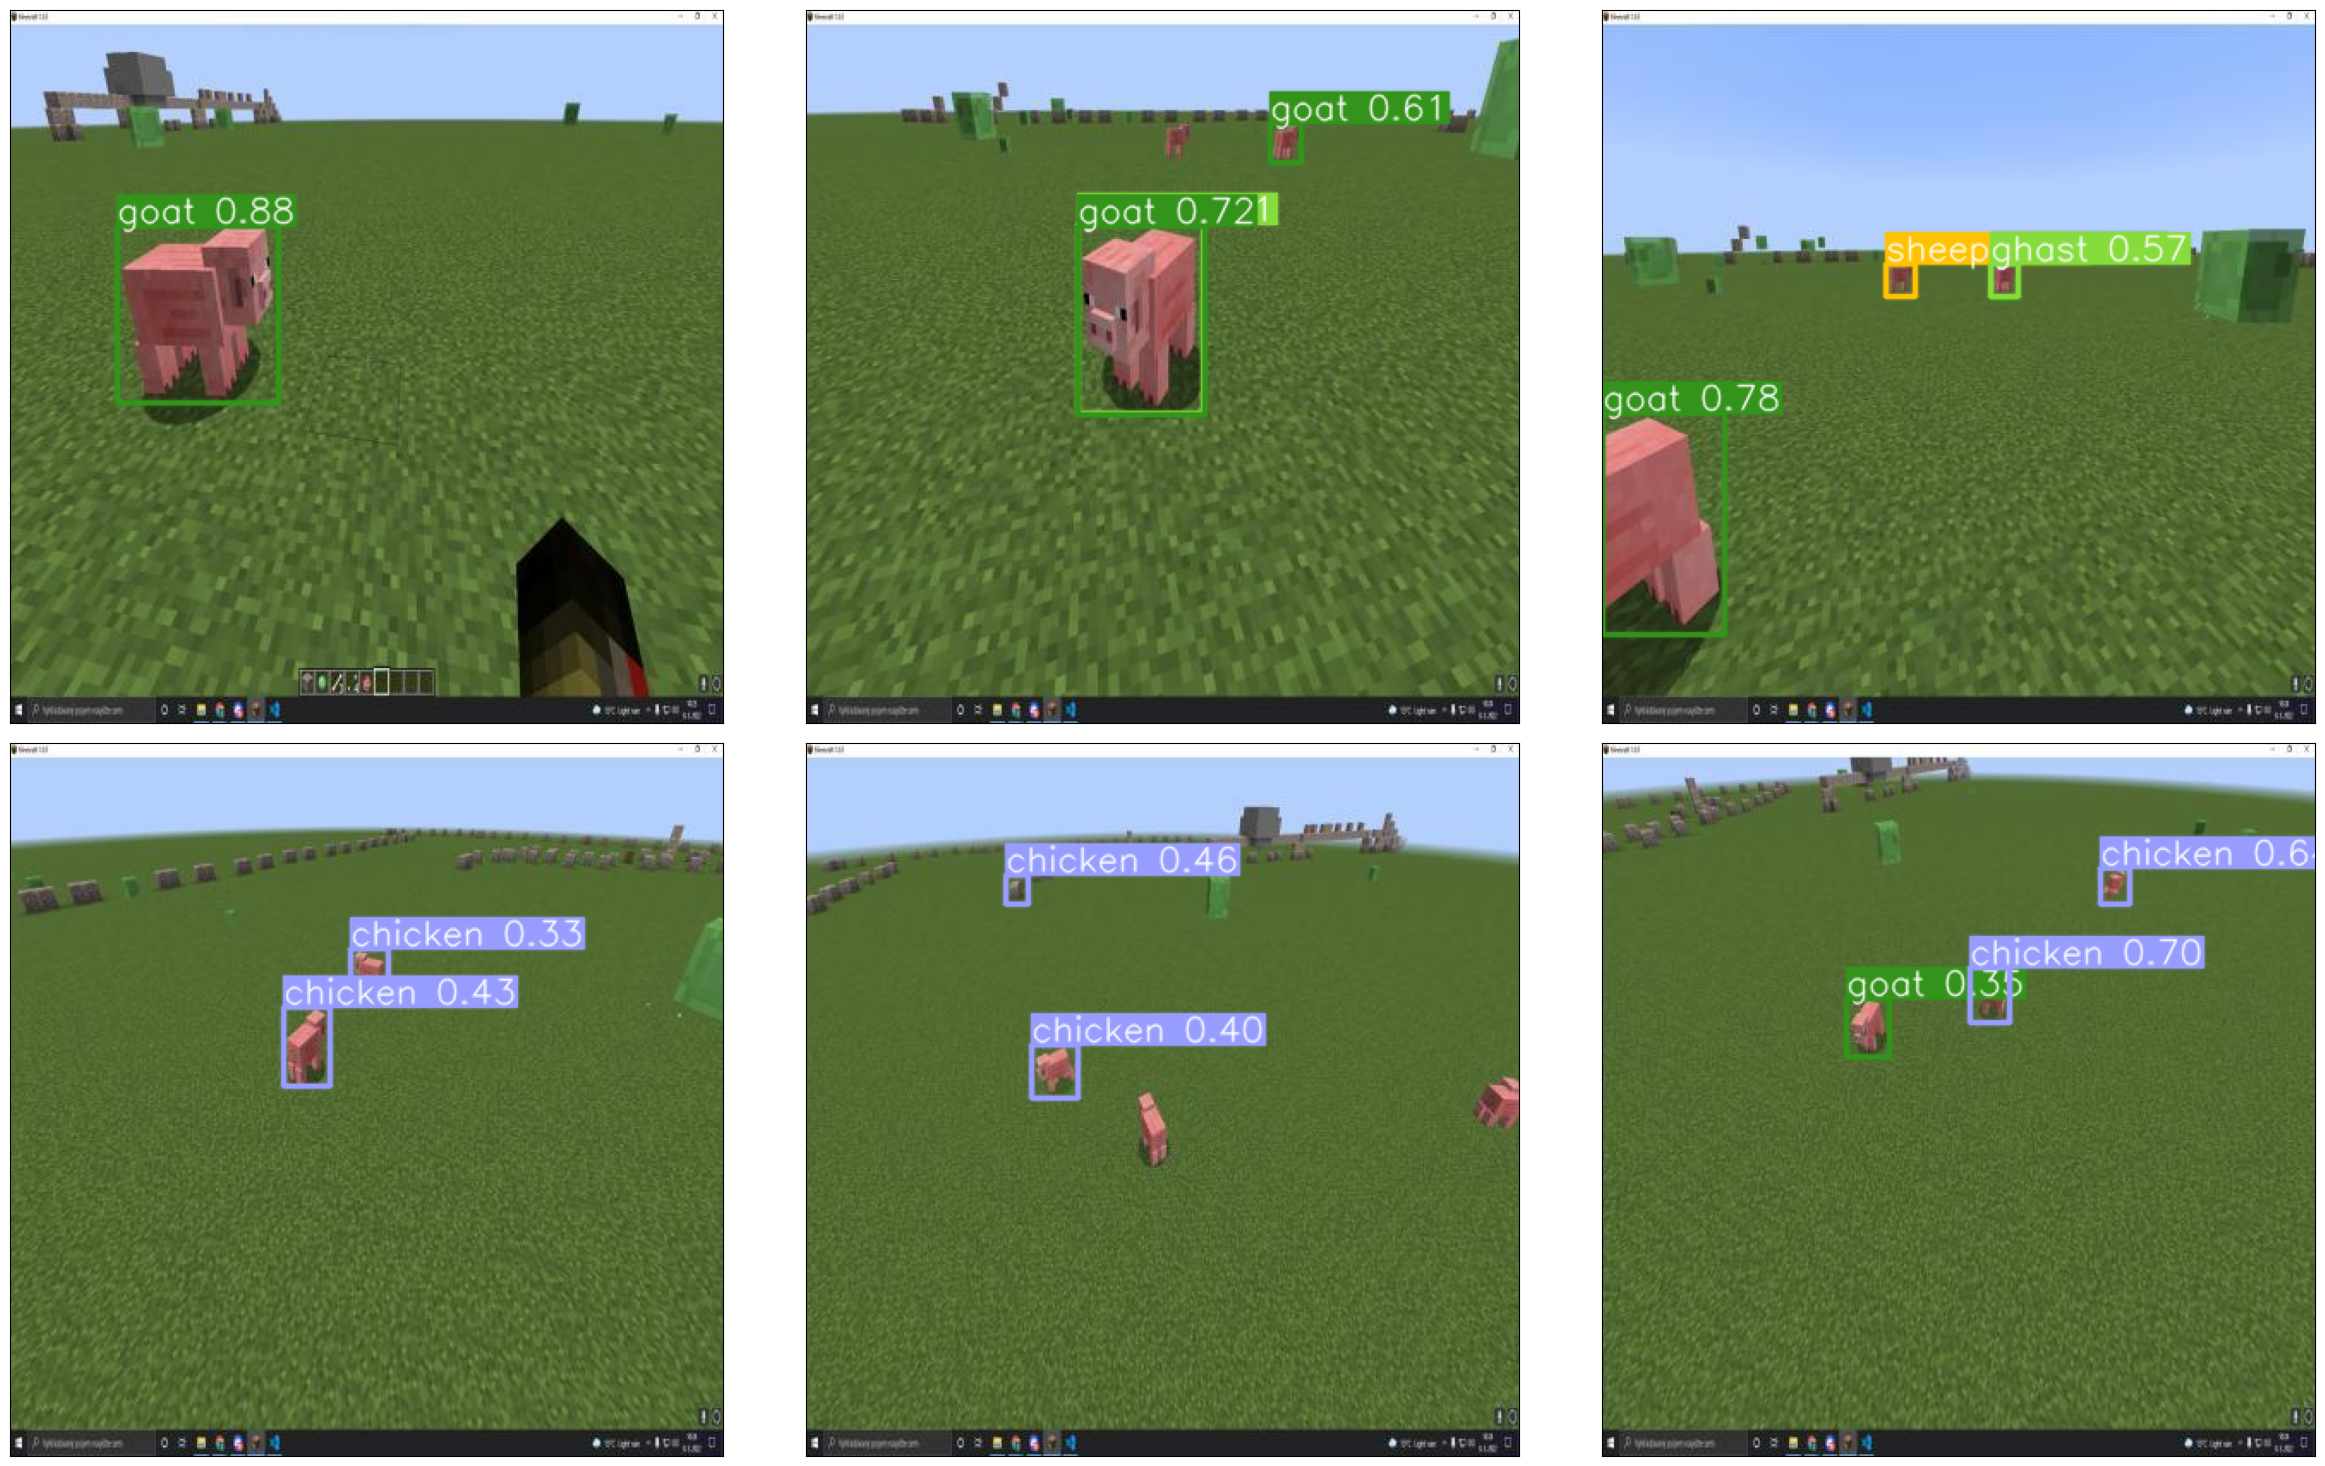

In [6]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

best_model = r'artifacts\yolo_training\yolov8s_minecraft_v1\weights\best.pt'
model = YOLO(best_model)

image_name = os.listdir(r'mmdetection\datasets\minecraft_yolo\test\images')
image_name = image_name[100:106]
dir = r"mmdetection\datasets\minecraft_yolo\test\images"

plt.figure(figsize=(25,15))
for i in range(1, 7):
    image = cv2.imread(os.path.join(dir, image_name[i-1]))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = model(image_rgb)
    results = results[0]
    annotated_image = results.plot()

    plt.subplot(2, 3, i)
    plt.imshow(annotated_image)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

    

Проверка инференса на видео. Результат можно посмотреть в minecraft_video_result.mp4

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os

model_path = r'artifacts\yolo_training\yolov8s_minecraft_v1\weights\best.pt'
model = YOLO(model_path)

input_video_path = r'mmdetection\datasets\minecraft_yolo\video.mp4'
cap = cv2.VideoCapture(input_video_path)

output_video_path = "minecraft_video_result.mp4"



if not cap.isOpened():
    print(f"Ошибка: не удалось открыть видеофайл {input_video_path}")
    exit()

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


with tqdm(total=total_frames, desc="Анализ игрового процесса") as pbar:
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        results = model.predict(frame, imgsz=640, conf=0.25, verbose=False)

               
        for r in results:
            for box in r.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf, class_id = float(box.conf[0]), int(box.cls[0])
                label = f"{model.names[class_id]} {conf:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (10, 0, 200), 2)

        out.write(frame)
        pbar.update(1)

cap.release()
out.release()
print(f"\nАнализ завершен. Результат сохранен в файл: {output_video_path}")

d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\.minecraft\lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi


Анализ завершен. Результат сохранен в файл: minecraft_video_result.mp4


### Этап 5. Сравнение стандартных метрик

In [37]:
import pandas as pd

df_fcos = pd.read_csv(r'fcos_metrics.csv')
df_yolo = pd.read_csv(r'yolo_metrics.csv')

df = pd.concat([df_fcos, df_yolo], axis=0, ignore_index=True)
df

model  mAP50-95  mAP50  precision  recall  f1_score
0     fcos     0.000  0.000        0.0  0.0029    0.0001
1  yolov8s     0.995  0.995        1.0  1.0000    1.0000

### Этап 6. Измерение FPS и визуализация результатов для обученных моделей

На этом этапе будет выполнено:
1. Загрузка обученных моделей YOLOv8s и FCOS
2. Визуализация результатов детекции на 3 тестовых изображениях для каждой модели
3. Измерение FPS для обеих моделей


In [14]:
# Импорт функций из fps.py
from fps import (
    load_fcos_model, 
    run_and_visualize_minecraft, 
    measure_fps_minecraft,
    MINECRAFT_CLASSES
)
from ultralytics import YOLO
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from config import CONFIG

# Проверка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


Используемое устройство: cpu


In [15]:
# Загрузка моделей
yolo_path = 'artifacts/yolo_training/yolov8s_minecraft_v1/weights/best.pt'
fcos_path = 'artifacts/fcos_scratch/fcos_minecraft.pt'

print("Загрузка моделей...")
yolo_model = YOLO(yolo_path).to(device)
fcos_model = load_fcos_model(fcos_path, device, num_classes=17, img_size=CONFIG['img_size'])
print("✅ Модели успешно загружены!")


Загрузка моделей...


d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\.minecraft\lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi

✅ Модели успешно загружены!


d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\fps.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

Используемые тестовые изображения:
  - -20-_jpg.rf.b6e634a136dcfb16a7a07cda96072ab8.jpg
  - -21-_jpg.rf.23982f2775c558c4c37a09bbaa2208b4.jpg
  - -22-_jpg.rf.5e6e148f7c954ad021a5ef8eb50ed754.jpg


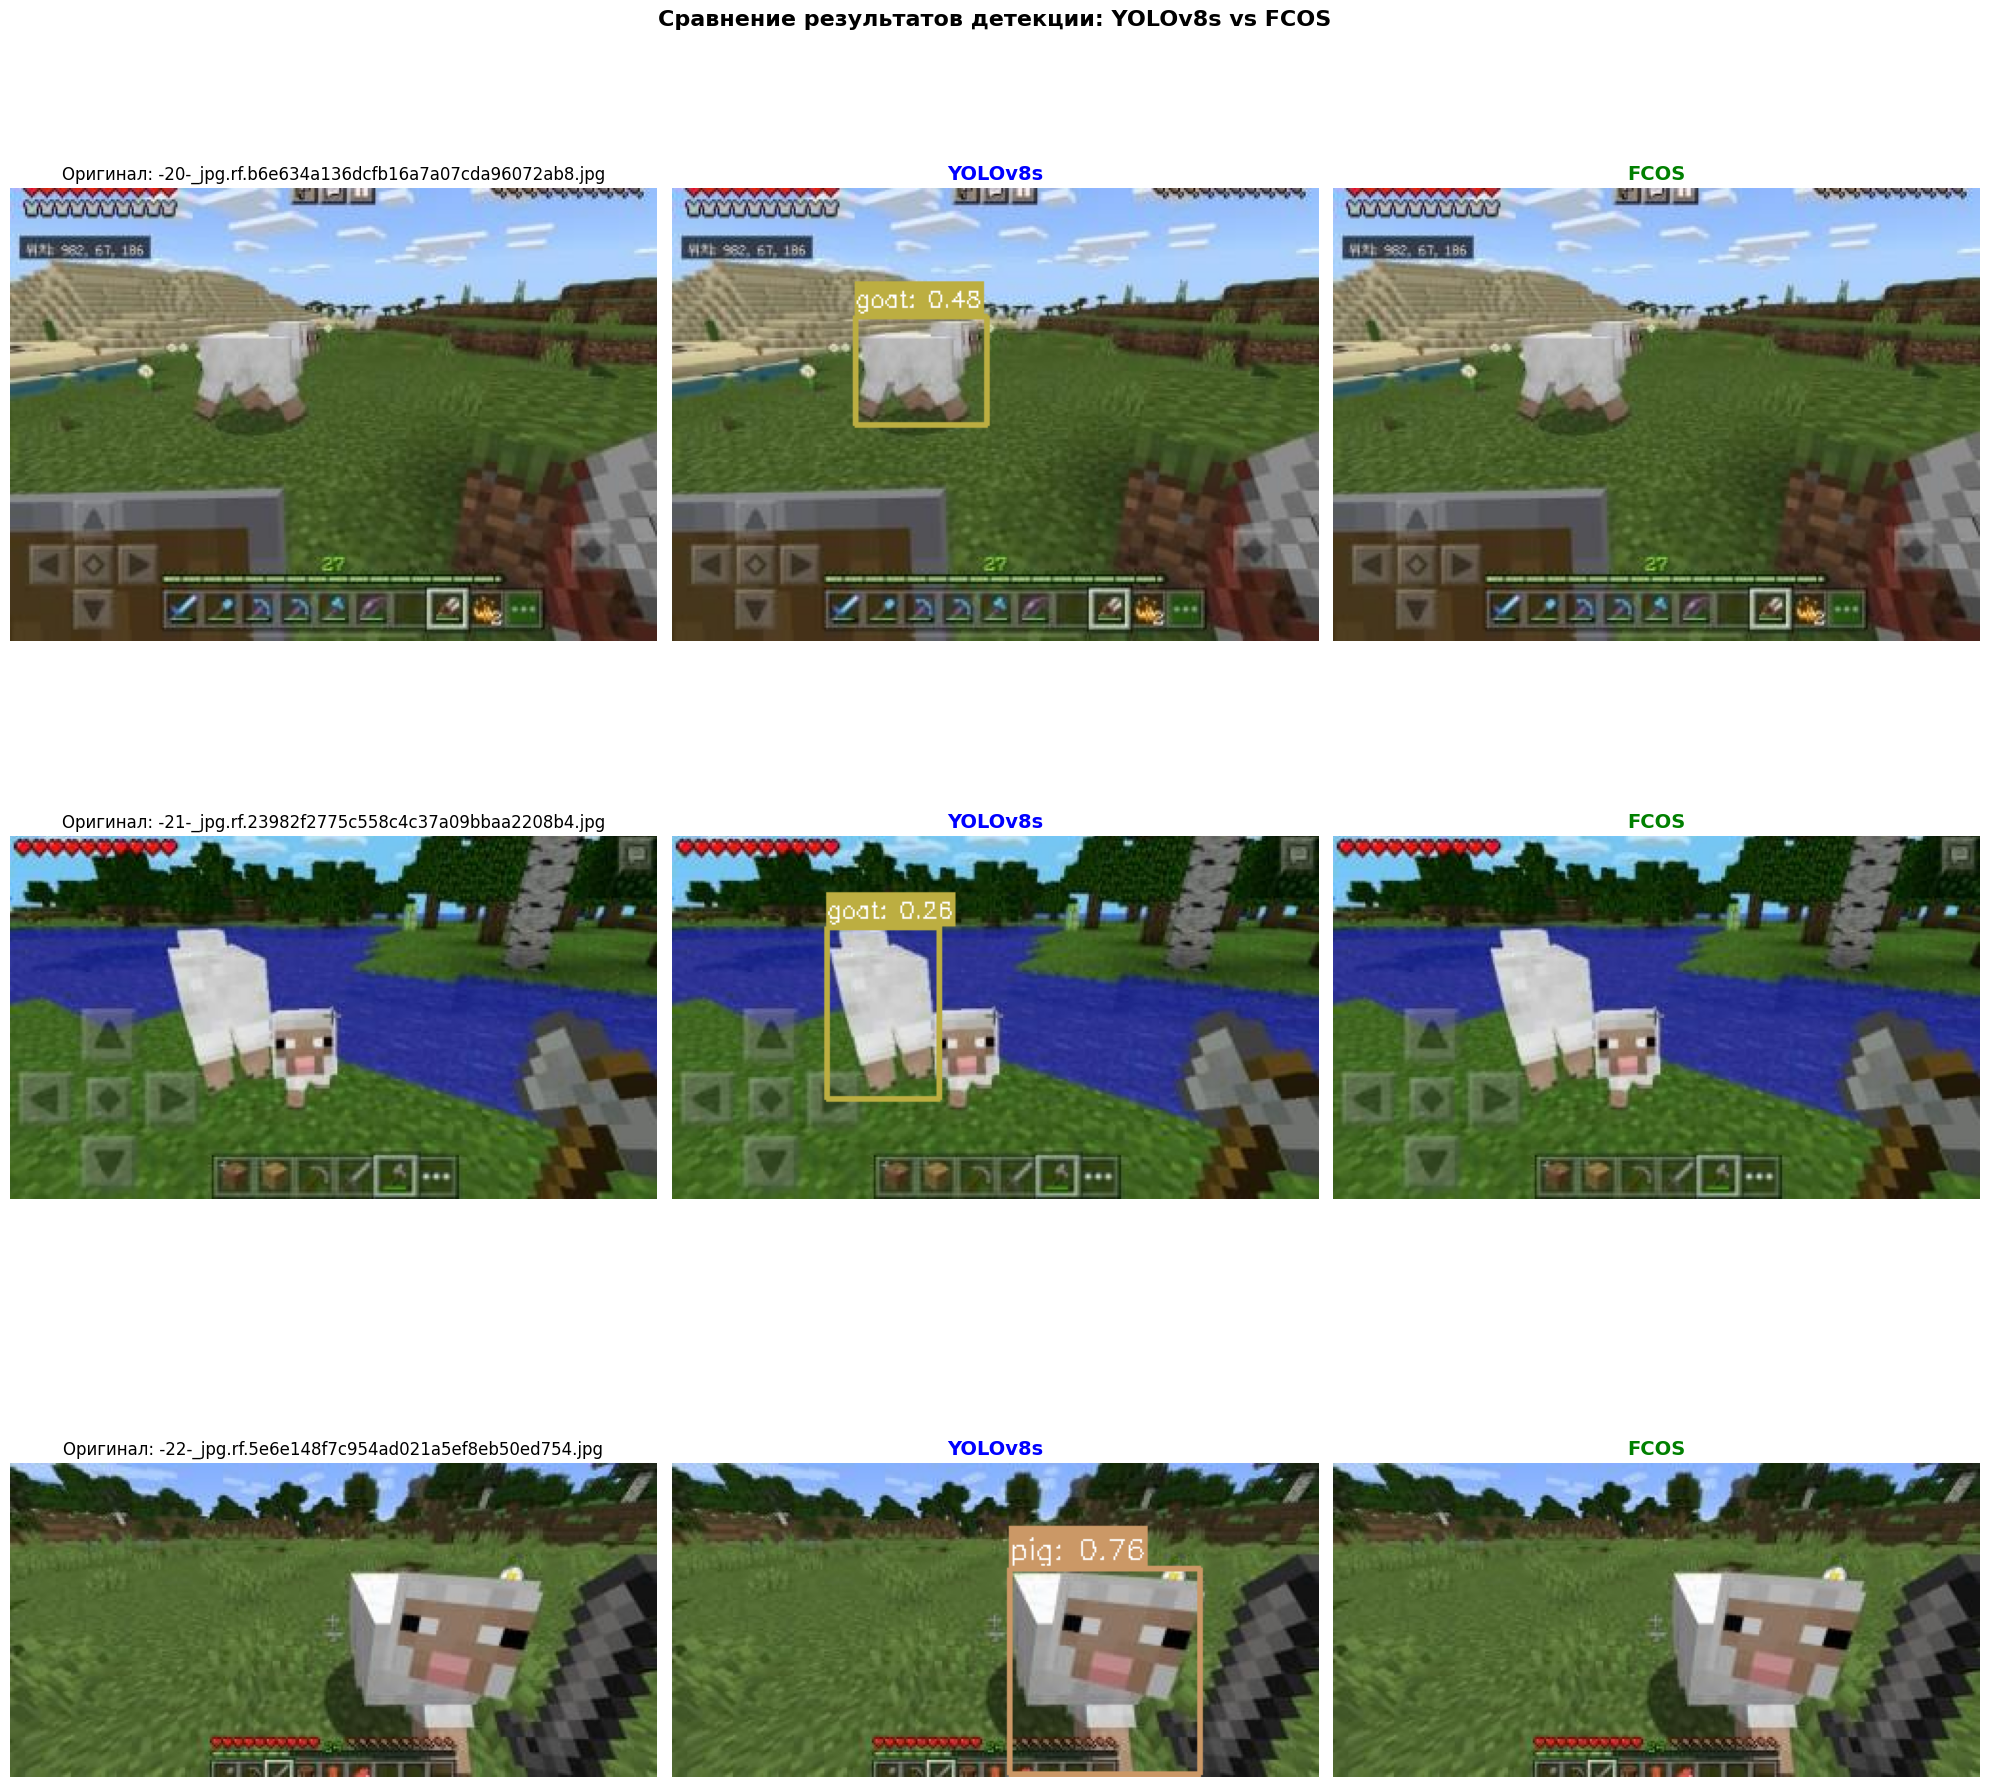

In [16]:
# Выбор 3 тестовых изображений
test_dir = Path('mmdetection/datasets/minecraft/test')
test_images = sorted(list(test_dir.glob('*.jpg')))[:3]

print(f"Используемые тестовые изображения:")
for img_path in test_images:
    print(f"  - {img_path.name}")

# Визуализация результатов для каждого изображения
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for idx, img_path in enumerate(test_images):
    yolo_img, fcos_img, orig_img = run_and_visualize_minecraft(
        str(img_path), yolo_model, fcos_model, device, 
        threshold=0.25, img_size=CONFIG['img_size'], show_text=True
    )
    
    # Отображение оригинального изображения
    axs[idx, 0].imshow(orig_img)
    axs[idx, 0].set_title(f'Оригинал: {img_path.name}', fontsize=12)
    axs[idx, 0].axis('off')
    
    # YOLO результаты
    axs[idx, 1].imshow(yolo_img)
    axs[idx, 1].set_title('YOLOv8s', fontsize=14, fontweight='bold', color='blue')
    axs[idx, 1].axis('off')
    
    # FCOS результаты
    axs[idx, 2].imshow(fcos_img)
    axs[idx, 2].set_title('FCOS', fontsize=14, fontweight='bold', color='green')
    axs[idx, 2].axis('off')

plt.suptitle('Сравнение результатов детекции: YOLOv8s vs FCOS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [17]:
# Измерение FPS
models_dict = {
    'yolo': yolo_model,
    'fcos': fcos_model
}

fps_results = measure_fps_minecraft(
    models_dict, 
    [str(img) for img in test_images], 
    num_runs=100, 
    device=device,
    img_size=CONFIG['img_size']
)

# Визуализация результатов FPS
print("\n" + "="*50)
print("Сводная таблица FPS")
print("="*50)
import pandas as pd
fps_df = pd.DataFrame([fps_results]).T
fps_df.columns = ['FPS']
fps_df = fps_df.sort_values('FPS', ascending=False)
print(fps_df)


Прогрев моделей...
Измерение FPS для YOLOv8...
Измерение FPS для FCOS...

================================================== Результаты измерения FPS ==================================================
FCOS           : 16.91 FPS
YOLOv8s        : 8.28 FPS

Сводная таблица FPS
               FPS
FCOS     16.910052
YOLOv8s   8.280626


### Этап 7. Генерация PDF отчета

На этом этапе будет сгенерирован PDF отчет со всеми результатами:
- Сравнение метрик качества
- Графики кривых обучения
- Примеры детекций
- Сравнение FPS
- Выводы и рекомендации


In [13]:
# Генерация PDF отчета
from generate_report import generate_report

print("Запуск генерации PDF отчета...")
print("Это может занять несколько минут...")
generate_report()
print("\n✅ Отчет успешно создан: artifacts/report.pdf")


Запуск генерации PDF отчета...
Это может занять несколько минут...
Начинаем генерацию отчета...
Устройство: cpu
Загрузка метрик...
Загрузка моделей...


d:\My documents\Desktop\Basic\Yandex Practicum DL CV\2. Course «Computer Vision — CV»\Split 1. Object detection\Minecraft_detect\.minecraft\lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi

Измерение FPS...
Прогрев моделей...
Измерение FPS для YOLOv8...
Измерение FPS для FCOS...

================================================== Результаты измерения FPS ==================================================
FCOS           : 8.31 FPS
YOLOv8s        : 5.43 FPS
Создание PDF отчета: artifacts/report.pdf
Создание графиков сравнения метрик...
Создание графиков кривых обучения...
Создание примеров детекций...
Создание графика FPS...
✅ Отчет успешно создан: artifacts/report.pdf

✅ Отчет успешно создан: artifacts/report.pdf
